# Classification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.metrics import f1_score, roc_auc_score, roc_curve

## Analysis on Response Regulators

In [2]:
dataset = "RR"
t1 = 0.4
num_train_samples = 100
plm_model = "protbert"
methods = ["MSA", "RBM", "Foundation", "Contrastive"]

In [3]:
def load_data(method, num_train_samples):
    key = f"embedding_{method.lower()}" if method in ["Contrastive", "Foundation"] else method.lower()
    filename = f"../experiments/datasets/{dataset}/t1{t1}_t20.7/test.{key}_{num_train_samples}.npz"
    data = np.load(filename, allow_pickle=True)
    return data

In [6]:
# load data
fname_test = f"../experiments/datasets/{dataset}/t1{t1}_t20.7/test.csv"
df_test = pd.read_csv(fname_test)
y_true = df_test["label"].values
unique_labels = np.unique(y_true)

data = {method: load_data(method, num_train_samples) for method in methods}

Average ROC curves for a given `t1` for each different embedding type

In [7]:
# compute roc curve
def compute_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)
    return fpr, tpr, roc_auc

In [8]:
from sklearn.preprocessing import label_binarize

def multiclass_average_roc(y_true, y_probs, classes=None):
    """
    Computes the average ROC curve and AUC score for multiclass classification.
    
    Parameters:
        y_true (array-like): True labels (shape: [n_samples])
        y_probs (array-like): Predicted probabilities (shape: [n_samples, n_classes])
        classes (array-like, optional): List of all class labels. If None, inferred from y_true.
        
    Returns:
        mean_fpr (np.ndarray): Mean false positive rates.
        mean_tpr (np.ndarray): Mean true positive rates (averaged across classes).
        mean_auc (float): Mean AUC score across classes.
    """
    if classes is None:
        classes = np.unique(y_true)
    y_true_bin = label_binarize(y_true, classes=classes)
    n_classes = len(classes)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i, c in enumerate(classes):
        fpr[c], tpr[c], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc[c] = roc_auc_score(y_true_bin[:, i], y_probs[:, i])
    
    # Interpolate all ROC curves at the same points
    all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
    mean_tpr = np.zeros_like(all_fpr)
    for c in classes:
        mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])
    mean_tpr /= n_classes
    mean_auc = np.mean(list(roc_auc.values()))
    
    return all_fpr, mean_tpr, mean_auc, (fpr, tpr, roc_auc)

In [9]:
# use latex
plt.rc('text', usetex=True)
# set font size
plt.rc('font', size=14)

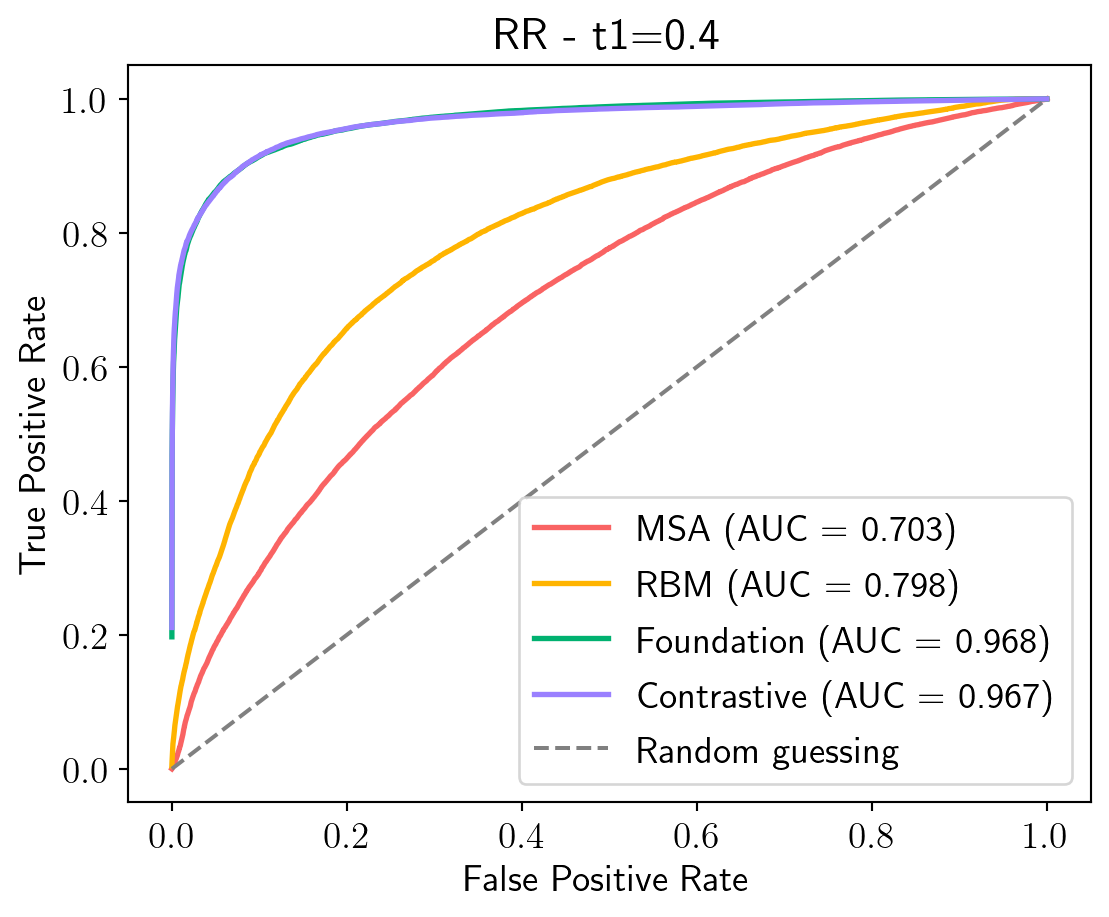

In [10]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=192)
colors = {
    "msa": "#f96363",
    "rbm": "#ffb400",
    "foundation": "#00b170",
    "contrastive": "#9a80ff",
}
roc_data = dict()
for i, method in enumerate(methods):
    y_scores = data[method]["probs"]
    color = colors[method.lower()]
    if len(unique_labels) == 2:
        fpr, tpr, roc_auc = compute_roc_curve(y_true, y_scores[:, 1])
        ax.plot(fpr, tpr, color=color, label=f"{method} (AUC = {roc_auc:.3f})", linewidth=2)
    else:
        fpr, tpr, roc_auc, roc_data_method = multiclass_average_roc(y_true, y_scores)
        ax.plot(fpr, tpr, color=color, label=f"{method} (AUC = {roc_auc:.3f})", linewidth=2)
    roc_data[method] = roc_data_method
        
        
ax.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random guessing')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
#ax.set_title(f't1={t1}')
ax.set_title(f'RR - t1={t1}')
ax.legend()
plt.tight_layout()

Roc curves by label

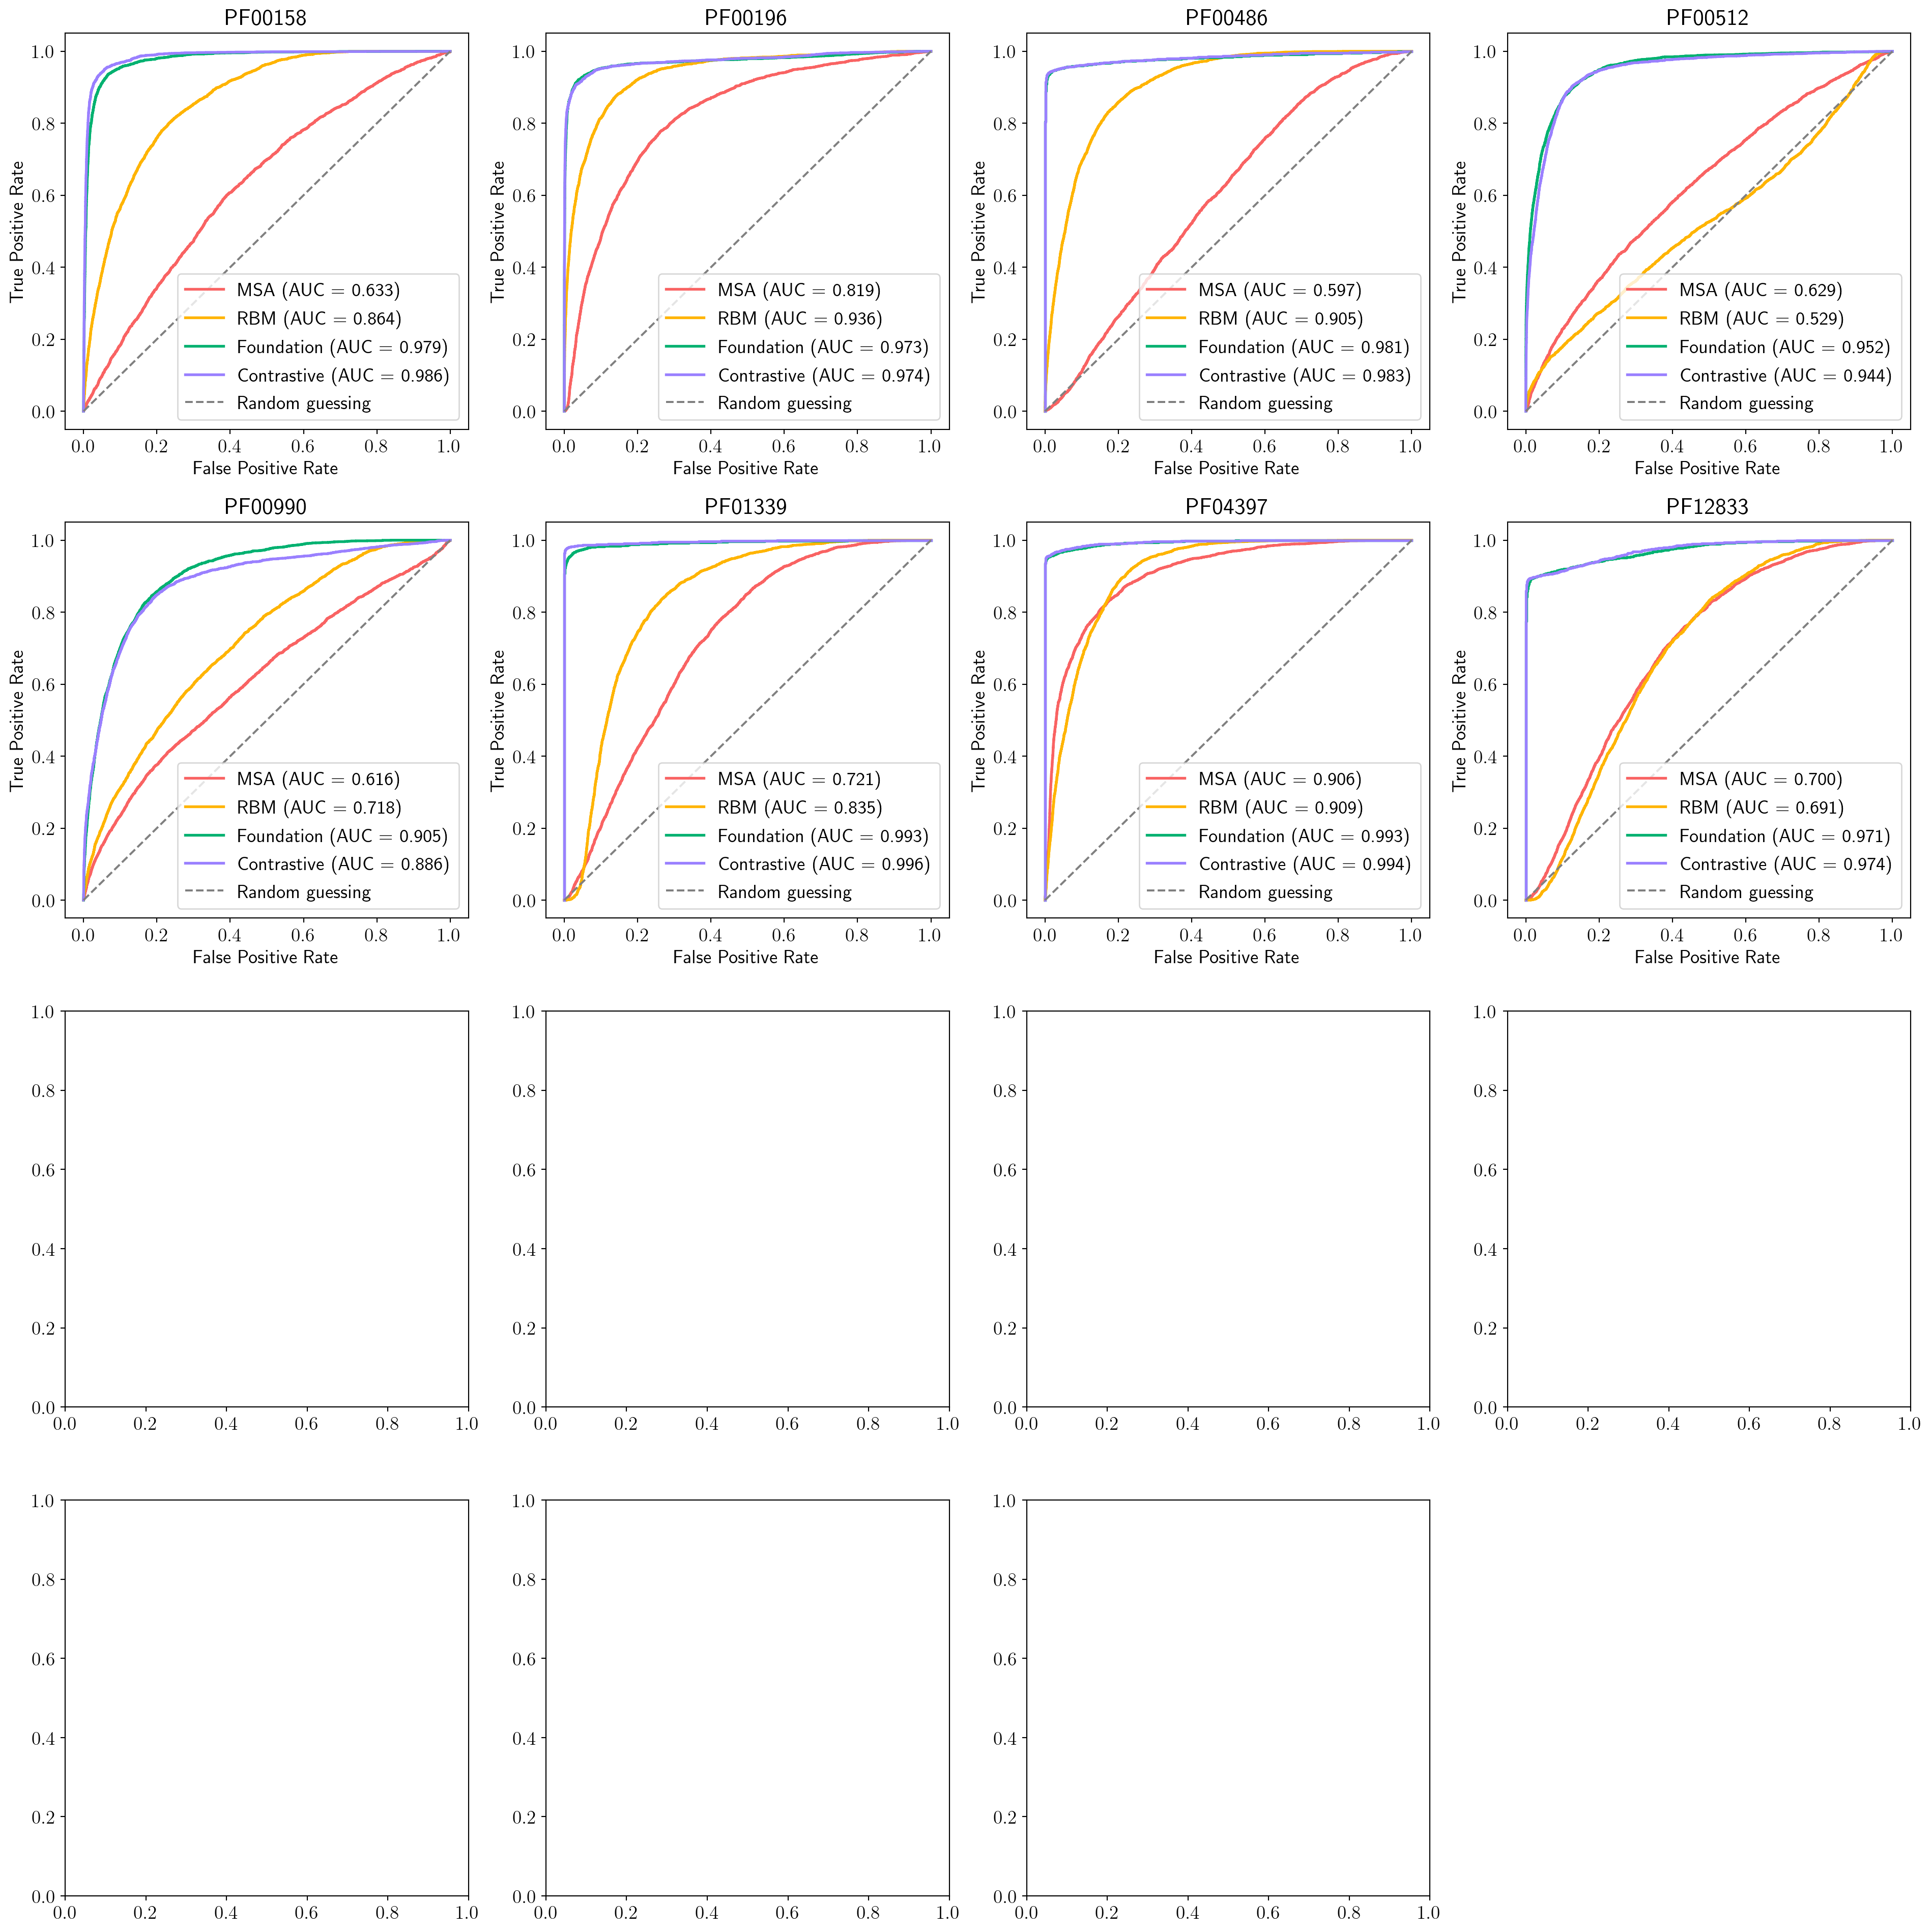

In [11]:
# Plot the ROC curves by label using roc_data
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20), dpi=192)
axes = axes.flatten()
for i, label in enumerate(unique_labels):
    ax = axes[i]
    for method, roc_data_method in roc_data.items():
        fpr, tpr, roc_auc = roc_data_method[0][label], roc_data_method[1][label], roc_data_method[2][label]
        color = colors[method.lower()]
        ax.plot(fpr, tpr, color=color, label=f"{method} (AUC = {roc_auc:.3f})", linewidth=2)
    
    ax.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random guessing')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{label}')
    ax.legend()
    
for ax in axes[-1:]:
    ax.axis('off')  # Hide unused subplots   
    
plt.tight_layout()
plt.show()

F1 scores for different methods and number of training sequences

In [12]:
# for num_train_samples in [100, 500, 1000, 2000] and each method, produce a dataframe with a columns: method, num_train_samples, f1 score
num_train_samples_list = [100, 500, 1000, 2000]
def get_df_f1_scores(data, y_true):
    f1_scores = []
    for method in methods:
        for num_train_samples in num_train_samples_list:
            data = load_data(method, num_train_samples)
            y_labels = data["labels"]
            f1 = f1_score(y_true, y_labels, average='macro')
            f1_scores.append({
                "method": method,
                "num_train_samples": num_train_samples,
                "f1_score": f1
            })
    return pd.DataFrame(f1_scores)

df_f1_scores = get_df_f1_scores(data, y_true)


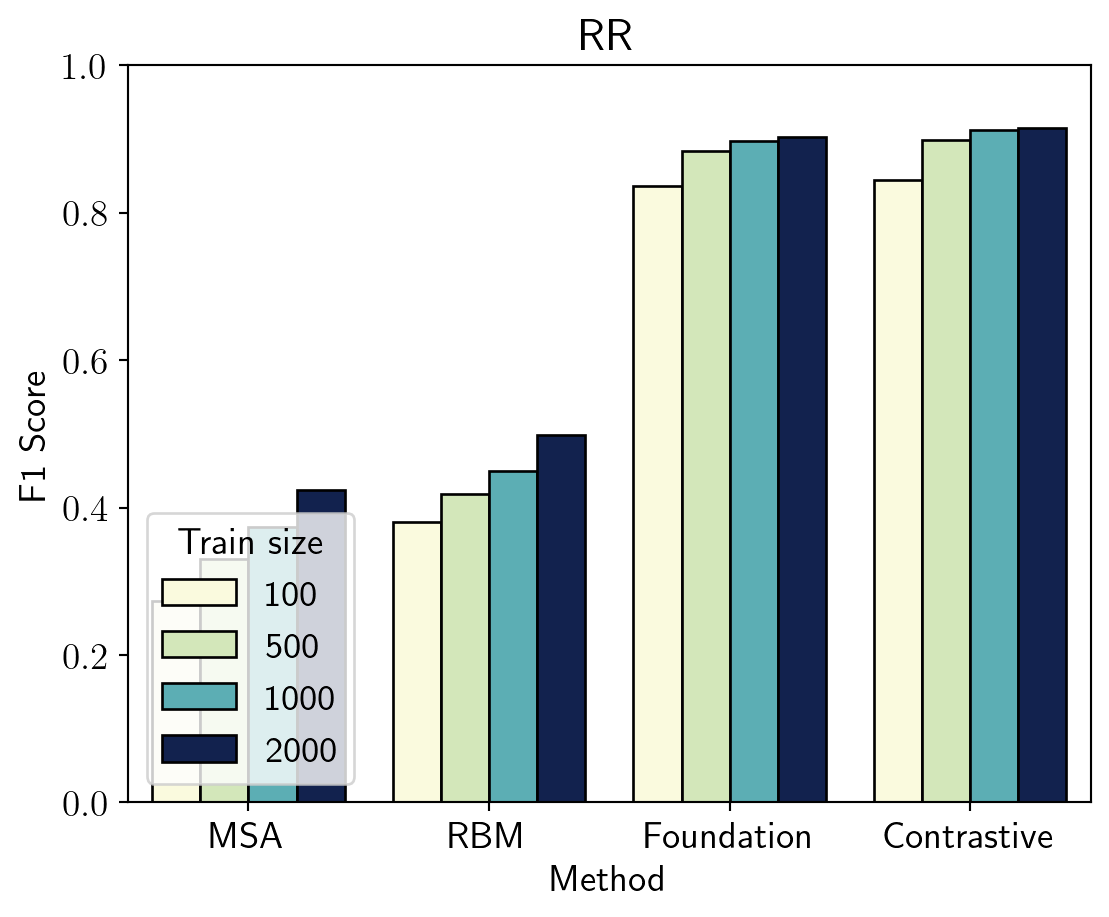

In [13]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=192)
sns.barplot(
    data=df_f1_scores,
    x="method",
    y="f1_score",
    hue="num_train_samples",
    ax=ax,
    palette="YlGnBu",
    edgecolor="black",   # Add black border to bars
    linewidth=1          # Set border thickness
)
ax.set_ylabel(r"F1 Score")
ax.legend(title="Train size", loc='lower left')
ax.set_ylim(0, 1)
#ax.set_title(f"t1={t1}")
ax.set_title(f"{dataset}")
ax.set_xlabel("Method")
plt.tight_layout()
plt.show()